<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 6 Lecture 1</div>
<div style="text-align: right">Dino Konstantopoulos, 11 October 2022, with material by Chris Fonnesbeck, Cyrille Rossant, and Pedro Domingos</div>
<div style="text-align: right"><i>please browse all URLs in this notebook</i></div>

# Transforming Distributions and Support Vector Machines
We review basic distributions, but this time we use another library that we're going to use with bayesian statistics, called `pymc3`. We introduce basic helper transformations on distributions, and we introduce Supoort Vector Machines (SVM), the 2nd most popular Machine Learning algorithm after Random Forests (RF).

<div id="divCheckbox" style="display: none;">
"20102020"[::-1]
</div>

# 1. Classical statistics

>**Definition**: [Statistics](https://en.wikipedia.org/wiki/Statistics) is the study of the collection, organisation, analysis and interpretation of data. It is comprised of methods for describing and analysing non-deterministic phenomena, and describing them as functions of a random variable.

Examples:
Deterministic phenomena - can be precisely predicted:

* Orbits of planets.
* Chemical reactions.

Non-deterministic phenomena - include randomness:

* Heights of people in the US.
* Measurements of mineral ages in rock sample.

>**DEFINITION**: What is a **random variable**? Find the math definition [here](https://en.wikipedia.org/wiki/Random_variable). I prefer *this* definition: it's an Excel column of data. The $x$s are the *names* of each row (the keys). The $y$s are the cell *values*. $x$ is called the random variable, and $y$ is called its **range** $f(x)$. $f$ is the function we're after, to figure out from the data, by interpolation. Often, all we can get to is a bad *approximation*. The function $f$ should be revelatory of the *mechanism that produced the data*. $f$ is called the **model**. That is **data science** in a nutshell: find $f$ from the data. If you can only remember *one paragraph of text* from this class, this is the one.

A common question then follows: Wait a minute, the data may not be **random**. Why do we use the word ***random***?

<br />
<left>
<img src="ipynb.images/scratch-monkey.jpg" width=200 />
</left>

First of all, according to [Ramsey theory](https://en.wikipedia.org/wiki/Ramsey_theory), ideal randomness is *impossible*, especially for large structures. While disorder is more *probable* in general (just look at my bedroom any regular day), complete disorder is *impossible*. 

Misunderstanding of this can lead to numerous [conspiracy theories](https://en.wikipedia.org/wiki/Conspiracy_theory). Some not-so-smart ex-presidents are especially vulnerable to this.

Saying randomness is *impossible* is tantamount to saying that a Uniform distribution (weather conditions in our F1 problem, and something we'll examine further below) for the random variable is *not possible*. In other words, nature does not throw dice or flip a coin. There must be *some order* in the data if it's produced by a natural phenomenon, and a histogram can help detect this order. 

The number of emails you receive a day is ***not random***, meaning that if you count the humber of emails, all possible numbers are not equally probable! It's not like throwing the dice!

The corollary of this of course is that if data is not random, you can *model* it and *predict* it! But there's a big difference between data that is truly random, and thus by definition cannot ***ever*** be predicted, and random-looking data that often can.

So, we use the word *random* variable, but that's only because the data *looks* random. But we know it's never really random.
<left>
<img src="ipynb.images/smart-monkey.jpg" width=300 />
</left>

The primary goal of statistical data analysis is to create a **model** for the data so you can throw away the data and use the model instead. 

A model's goal is usually to relate the influence of one variable on another. For example, how different medical interventions influence the incidence or duration of disease, how baseball players' performance varies as a function of age, how the Coronavirus influences the stock market or how the body mass index predicts it. 

The independent variable(s) $x$ is(are) called the **predictor** variable(s). The variable(s) $y$ to predict is(are) called the **dependent** variable(s), or target(s). We build the function approximation that gives us $y$ from $x$. *That* ***is*** data science.

**Bayesian models**, which we're going to look at soon, involve advanced probabilistic programming. Only in the last few decades do we have the computer power to run these kinds of programs.

The two most successful statistical data science methods ***prior*** to the resounding success of modern Bayesian estimation are the [Method Of Moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)) (MOM) and [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE). 

# 2. Classic Distributions

Statistical **point** ***features*** is probably the most used statistics concept in data science. It is often
the first statistics technique you would apply when exploring a column of a dataset (i.e. a *random variable*)
and includes concepts such as **bias, variance, mean, median, percentiles**, and others. It’s all fairly easy to
understand and implement in code, and `pandas`'s `.describe()` dataframe API gives you most of them!

A **box (or whisker) plot** perfectly illustrates what we can do with basic statistical features of a random variable:

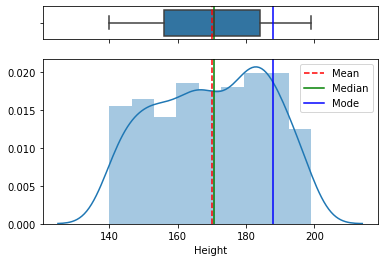

In [50]:
#from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv("data/500_Person_Gender_Height_Weight_Index.csv")
df.head()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=df['Height'].mean()
median=df['Height'].median()
mode=df['Height'].mode()[0]

sns.boxplot(df["Height"], ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(df["Height"], ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')
ax_hist.axvline(mode, color='b', linestyle='-')

plt.legend({'Mean':mean,'Median':median,'Mode':mode})

ax_box.set(xlabel='')
plt.show()

The **whisker plot** is the first graph above.

- The line in the middle is the median value of the data. Median is often used over the mean
since it is more robust to outlier values. Median is the middle point of your dataset, and mode is the most frequently occurring value. The first quartile is essentially the 25th
percentile; i.e 25% of the points in the data fall below that value. The third quartile is the
75th percentile; i.e 75% of the points in the data fall below that value. The min and max
values represent the upper and lower ends of our data range.

- When the box plot is short it implies that much of your data points are similar, since
there are many values in a small range

- When the box plot is tall it implies that much of your data points are quite different,
since the values are spread over a wide range

- If the median value is closer to the bottom then we know that most of the data has
lower values. If the median value is closer to the top then we know that most of the
data has higher values. Basically, if the median line is not in the middle of the box
then it is an indication of skewed data.

- Are the whiskers very long? That means your data has a high standard deviation
and variance i.e the values are spread out and highly varying. If you have long
whiskers on one side of the box but not the other, then your data may be highly
varying only in one direction.

The **histogram**, the second plot, below the whisker plot is super-important: It tells us *how* the data is distributed and gives us the opportunity to *find the function that approximates our data*: It needs to produce (fake) data that has the same histogram as the real data. The histogram is a **probability distribution**.

>**DEFINITION**: A **probability distribution** is a function which represents the probabilities of all possible values in an experiment

>**DEFINITION**: The **expected value** of a discrete random variable is the probability-weighted average of all its possible values. In other words, each possible value the random variable can assume is multiplied by its probability of occurring, and the resulting products are summed to produce the expected value. Intuitively, a random variable's expected value represents the mean of a large number of independent realizations of the random variable. The expected value is also known as the **expectation**, mathematical expectation, **mean**, or **first moment**.

Here are the classic theoretical distributions whose histograms are very well-defined and which happen to model data that usually occurs on planet Earth (much like the Fibonacci numbers and the Golden ratio appear in nature). You need to know all of these for your data science interviews.

- A [Bernoulli Distribution]() has only two possible outcomes and a single trial. A simple example can be a single toss of a biased/unbiased coin. In this example, the probability that the outcome might be heads can be considered equal to p and (1 - p) for tails (the probabilities of mutually exclusive events that encompass all possible outcomes needs to sum up to one).


- A [binomial Distribution]() can be thought as the sum of outcomes of an event following a Bernoulli distribution. The Binomial Distribution is therefore used in binary outcome events and the probability of success and failure is the same in all the successive trials. This distribution takes two parameters as inputs: the number of times on event takes place and the probability assigned to one of the two classes. The binomial distribution is frequently used to model the number of successes in a sample of size n drawn with replacement from a population of size N. If the sampling is carried out without replacement, the draws are not independent and so the resulting distribution is a hypergeometric distribution, not a binomial one. However, for N much larger than n, the binomial distribution remains a good approximatio. A simple example of a Binomial Distribution in action can be the toss of a biased/unbiased coin repeated a certain amount of times, or picking balls from an urn (with replacement) that contains balls of two different colors. The main characteristics of a Binomial Distribution are:
 - Given multiple trials, each of them is independent of each other (the outcome  of one trial doesn't affect another one).
 - Each trial can lead to just two possible results (eg. winning or losing), which have probabilities p and (1 - p).


- A [Uniform Distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)) is the most basic of the seven we show here. It has a *single value* which only occurs in a certain range while anything outside that range is just 0. It’s very much an *on or off* distribution. We can also think of it as an indication of a
categorical variable with 2 categories: 0 or the value. Your categorical variable might
have multiple values other than 0 but we can still visualize it in the same was as a
piecewise function of multiple uniform distributions.


- A [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution), commonly referred to as a **Gaussian Distribution**, is specifically defined by its **mean** and **standard deviation**. The mean value shifts the
distribution spatially (measure of *centrality*) and the standard deviation controls the *spread*. The import
distinction from other distributions (e.g Poisson) is that the standard deviation is the
*same in all directions*. Thus with a Gaussian distribution we know the average value
of our dataset as well as the spread of the data i.e is it spread over a wide range or is
it highly concentrated around a few values.


- A [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution) (that's the distribution that models the number of emails you receive every day!) is similar to the Normal but with an added factor of skewness. With a low value for the skewness a poisson distribution will have relatively uniform spread in all directions just like the Normal. But when the
skewness value is high in magnitude then the spread of our data will be different in one direction: It will be very *spread out* in one direction and in the other it will be *highly concentrated*. Poisson Processes are used to model a series of discrete events in which we know the average time between the occurrence of different events but we don’t know exactly *when* each of these events might take place. For example, events that can be counted (e.g. emails or text messages). A process can be considered to belong to the class of Poisson Processes if it can meet the following criterias:
 - The events are independent of each other (if an event happens, this does not alter the probability that another event can take place).
 - Two events can’t take place simultaneously.
 - The average rate between events occurrence is constant.


- A [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is a distribution that arises naturally in processes for which the ***waiting times between events are relevant***. It can be thought of as a **waiting time** between **Poisson distributed events**, such as in when you wait for the "T" (i.e. queuing models), climatology, and financial services. Examples of events that may be modeled by a gamma distribution include but are not limited to:
 
 - Public transportation
 - Amount of [rainfall](http://journals.tubitak.gov.tr/engineering/issues/muh-00-24-6/muh-24-6-7-9909-13.pdf). accumulated in a reservoir
 - The size of loan defaults or aggregate [insurance claims](https://www.crcpress.com/Statistical-and-Probabilistic-Methods-in-Actuarial-Science/Boland/p/book/9781584886952)
 - The flow of items through manufacturing and distribution processes
 - Visitors to a website
 - Customers calling a help center 
 - Radioactive decay in atoms
 - Movements in a stock price


- A [Random walk](https://en.wikipedia.org/wiki/Random_walk) (or [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion)) can be any sequence of discrete steps (of always the same length) moving in **random directions**. Random Walks can take place in any type of dimensional space (eg. 1D, 2D, nD).
Specfically, a **Random Walk** is used to describe a *discrete-time process* while **Brownian Motion** can be used to describe a continuous-time random walk. Some examples of random walks applications are: tracing the path taken by molecules when moving through a gas during the diffusion process, sports events predictions etc…


There are more theoretical distributions we'll learn in class but these seven already give
us a lot of value. We can quickly see and interpret our categorical variables with a
Uniform Distribution. There are many algorithms that by default will perform well specifically 
with Gaussian so we should use Gaussian Distribution as much as possible. And the Poisson and the Gamma/Brown 
model a lot of natural processes, respectively for discrete and continuous events.

# 3. Visualizing classic distributions with pymc3
I import a package we'll use a lot, later on. if you don't have it, then 
```(python)
pip install pymc3
```

## The Uniform distribution

Simplest of all: same probability $y$ for all possible values of the random variable $x$. Becomes apparent when we plot a lot of experiments. 

0.5133890058090604
0.2886983729119299


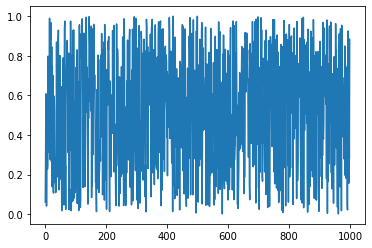

In [72]:
from pymc3 import Uniform

y = Uniform.dist()
samples = y.random(size=1000)
print(samples.mean())
print(samples.std())
plt.plot(samples)

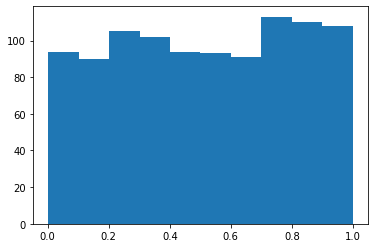

In [73]:
plt.hist(samples);

0.4989841378193897
0.2909107198226475


(array([ 992., 1047., 1021.,  987.,  994.,  973.,  943., 1013.,  972.,
        1058.]),
 array([6.71126755e-05, 1.00044413e-01, 2.00021714e-01, 2.99999015e-01,
        3.99976315e-01, 4.99953616e-01, 5.99930916e-01, 6.99908217e-01,
        7.99885518e-01, 8.99862818e-01, 9.99840119e-01]),
 <a list of 10 Patch objects>)

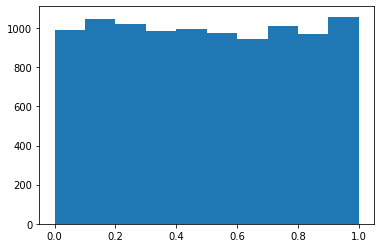

In [74]:
samples = y.random(size=10000)
print(samples.mean())
print(samples.std())
plt.hist(samples)

Why is the latter histogram *flatter*?

## The Bernoulli Distribution

Here we use `Scipy`, instead:

In [75]:
import scipy.stats as stats
# size = number of experiments
# p = probability of success
bern = stats.bernoulli.rvs(size=10000, p = 0.5)

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Bernoulli Distribution')]

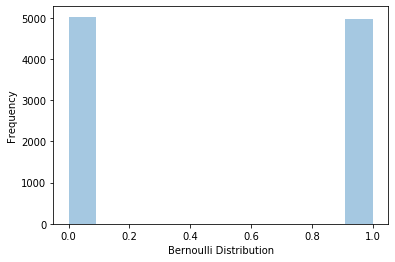

In [76]:
ax= sns.distplot(bern,
                 kde=False)
ax.set(xlabel='Bernoulli Distribution', ylabel='Frequency')

In [77]:
biased_bern = stats.bernoulli.rvs(size=1000, p=0.7)

ax= sns.distplot(biased_bern,
                 kde=False)
ax.set(xlabel='Bernoulli Distribution', ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Bernoulli Distribution')]

Let's build a **model** for a fair coin toss:

In [78]:
probs = np.full((2), 1/2)
face = [0,1]

Let's plot it:

(0, 1)

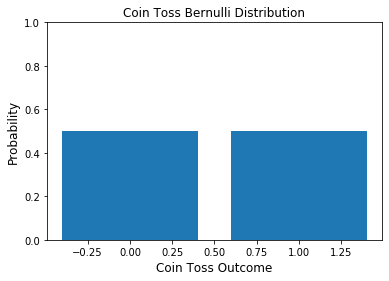

In [29]:
plt.bar(face, probs)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Coin Toss Outcome', fontsize=12)
plt.title('Coin Toss Bernulli Distribution', fontsize=12)
axes = plt.gca()
axes.set_ylim([0,1])

Let's build a **model** for a biased coin toss:

In [79]:
probs = np.array([0.75, 0.25])
face = [0, 1]

In [80]:
plt.bar(face, probs)
plt.title('Loaded coin Bernoulli Distribution', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Loaded coin Outcome', fontsize=12)
axes = plt.gca()
axes.set_ylim([0,1])

(0, 1)

## The binomial Distribution

The Binomial Distribution can be thought as the sum of outcomes of an event following a Bernoulli distribution. It takes two parameters as inputs: the number of times on event takes place and the probability assigned to one of the two classes.

The probability of getting exactly k successes in n independent Bernoulli trials is given by: 

$$p(k,n,p) = (^n_k) p^k (1-p)^{n-k}$$

where

$$(^n_k) = \frac{n!}{k!\;(n-k)!}$$

The probability of getting exactly k successes in n independent Bernoulli trials can be plotted:

In [81]:
# size = number of experiments
# n = number of trials (number of trials for each experiment)
# p = probability that one of two events is going to take place
binomial_data = stats.binom.rvs(size=10000, n=10, p=0.5, random_state=0)
pd.Series(binomial_data).plot(kind="hist", bins = 50)

So for n=10 and p=0.5, the probably of 5 successes is the highest, and the distribution of the number of successes is very gaussian-like!

Changing the probability value changes how the distribution looks like.

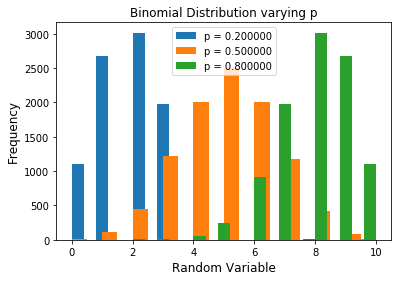

In [82]:
for prob in range(2, 10, 3):
    binomial_data = stats.binom.rvs(size=10000, n=10, p=0.1*prob, 
                                    random_state=0)
    
    pd.Series(binomial_data).plot(kind="hist", bins = 20, 
                              label="p = {:f}".format(0.1*prob))
    plt.xlabel('Random Variable', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title("Binomial Distribution varying p")
    plt.legend()

It *skews* the distribution to the left or the right!

## The Normal Distribution

Also known as the **gaussian** distribution.

For ***continuous random variables***:

$$X \in [0,1]$$

$$Y \in (-\infty, \infty)$$

Its **probability *density* function** (pdf): 

For continuous $X$,

$$Pr(x \le X \le x + dx) = f(x|\theta)dx \, \text{ as } \, dx \rightarrow 0$$

![Continuous variable](https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg)

<div style="font-size: 110%;">  
$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$$
</div>

* $X \in \mathbf{R}$
* $\mu \in \mathbf{R}$
* $\sigma>0$

The **expectation** (or first moment), and the **standard deviation** (or second moment) of a gaussian are:
$$\begin{align}E(X) &= \mu \cr
\text{Var}(X) &= \sigma^2 \end{align}$$

In [87]:
from pymc3 import Normal

y = Normal.dist(mu=-2, sd=4)
samples = y.random(size=1000)
print(samples.mean())
print(samples.std())
plt.plot(samples);

-1.7411723070331477
3.9762825735754195


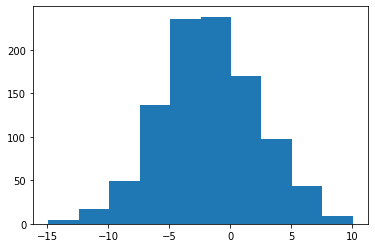

In [88]:
plt.hist(samples);

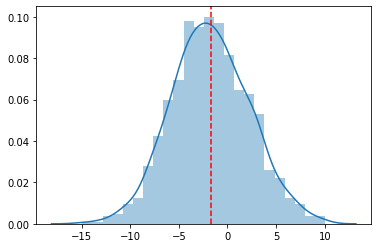

In [89]:
%matplotlib inline
sns.distplot(samples)
plt.axvline(samples.mean(), color='r', linestyle='--')

If you wanted to use `Scipy` to model the normal distribution, you would use the ***r***andom ***v***ariate***s*** API `.rvs()`:

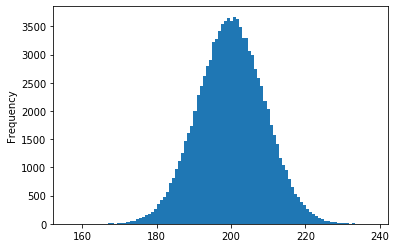

In [90]:
# size = number of data points
# loc = mean
# scale = standard deviation
normal_dist = stats.norm.rvs(size=100000, loc=200, scale=9, 
                             random_state=0) 

pd.Series(normal_dist).plot(kind="hist", bins=100)

Here we plot different means:

In [91]:
for mean in range(400, 900, 200):
    normal_dist = stats.norm.rvs(size=10000, loc=mean, scale=90, 
                             random_state=0) 
    pd.Series(normal_dist).plot(kind="hist", bins=100, 
                                label="Mean = {:f}".format(mean))
    plt.xlabel('Distribution', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title("Normal Distribution varying the mean")
    plt.legend()

## The Poisson distribution

For ***discrete random variables***, the Poisson distribution models **unbounded counts**:

$$X = \{0,1,2,3,\ldots \}$$

$$Y = \{\ldots,-2,-1,0,1,2,\ldots\}$$

Its **probability *mass* function**: 

$$Pr(X=x) = f(x\;|\; \lambda)$$

![Discrete variable](http://upload.wikimedia.org/wikipedia/commons/1/16/Poisson_pmf.svg)

<div style="font-size: 120%;">  
$$Pr(X=x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
</div>

* $X=\{0,1,2,\ldots\}$
* $\lambda > 0$

One useful property of the Poisson distribution is that its **expectation** (or first moment) as well as its **standard deviation** (or second moment) are equal to its *sole* parameter, i.e.:

$$E(X) = \text{Var}(X) = \lambda$$

Let's take random samples from a Poisson process and plot their histogram. You will see it reproduces a Poisson distribution. That is to say, random samples from a Poisson process yields a Poisson Distribution. This means that the statistics of a Poisson process are not exactly completely random. Rather, they follow a predictable behavior.

That is because Poisson processes model **counts**. For example, counts of SMS messages you receive per day. Let's say, if you're a popular student, you receive from 0 to 100 messages a day. On every single day, I can thus expect you receive about 50 messages, right? It's a rare day you receive 0, or 100.

In [92]:
from pymc3 import Poisson

x = Poisson.dist(mu=1)
samples = x.random(size=100)
print(samples.mean())
print(samples.std())
plt.plot(samples)

0.91
1.0207350292803712


1.009
1.016326227153467


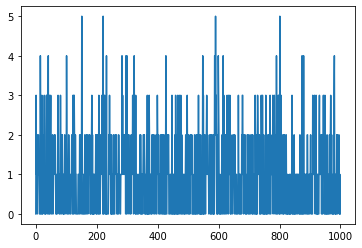

In [93]:
x = Poisson.dist(mu=1)
samples = x.random(size=1000)
print(samples.mean())
print(samples.std())
plt.plot(samples)

In [94]:
plt.hist(samples, bins=len(set(samples)));

We can also use `NumPy` to model a Poisson process:

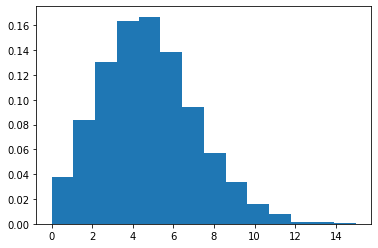

In [119]:
s = np.random.poisson(5, 10000)
plt.hist(s, 14, density=True)
plt.show()

In [71]:
np.random.poisson(lam=(100., 500.), size=(5, 2))

array([[ 91, 500],
       [ 91, 511],
       [102, 466],
       [104, 511],
       [ 97, 468]])

Here we see how the cumulative sum of a Poisson random variable is a linear curve, since the expectation is constant:

In [46]:
N = 100 # Events
lambdas = [0.5, 2, 4]
X_T = [np.random.poisson(lam, size=N) for lam in lambdas]
S = [[np.sum(X[0:i]) for i in range(N)] for X in X_T]
X = np.linspace(0, N, N)
 
# Plot the graph
graphs = [plt.step(X, S[i], label="λ = %f"%lambdas[i])[0] 
          for i in range(len(lambdas))]
plt.legend(handles=graphs)
plt.title("Poisson Process models unbounded counts")
plt.xlabel("Events")
plt.ylabel("Frequency")
plt.show()

And also `SciPy.stats`!

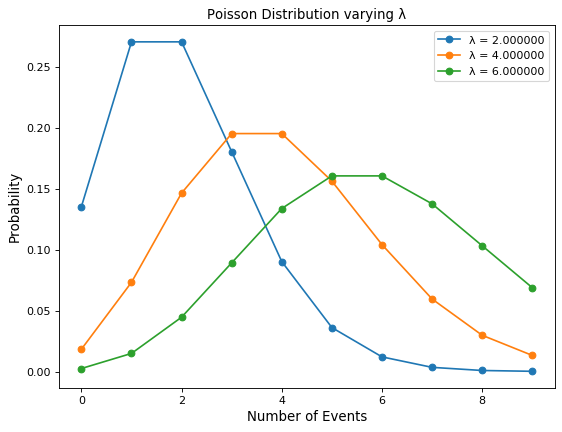

In [47]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# n = number of events, lambds = expected number of events which can take place in a period
for lambd in range(2, 8, 2):
    n = np.arange(0, 10)
    poisson = stats.poisson.pmf(n, lambd)
    plt.plot(n, poisson, '-o', label="λ = {:f}".format(lambd))
    plt.xlabel('Number of Events', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title("Poisson Distribution varying λ")
    plt.legend()

## The Gamma distribution

This is the [**gamma distribution**](https://en.wikipedia.org/wiki/Gamma_distribution):

<div style="font-size: 120%;">  
$$f(x) = \frac{\beta^\alpha x^{\alpha -1} e^{- \beta x}}{\Gamma (\alpha)}$$
</div>

And... what is the $\Gamma()$ function? It [interpolates](https://en.wikipedia.org/wiki/Gamma_function) the factorial function to non-integer values. Pretty cool.

The gamma distribution is a ***two-parameter*** ($\alpha, \beta$) family of ***continuous*** probability distributions. There are [three different parametrizations](https://en.wikipedia.org/wiki/Gamma_distribution) in common use! For the one here (more common in Bayesian statistics), the **expectation** (or first moment) of the Gamma is $E[x] = α/β$.

In Bayesian statistics, the **gamma distribution** is used as a [**conjugate prior**](https://en.wikipedia.org/wiki/Conjugate_prior) distribution for the **exponential distribution** and the **Poisson distribution**. In Bayesian probability theory (which we'll look into soon), if the posterior distributions $p(θ \;|\; x)$ are in the same probability distribution family as the prior probability distribution $p(θ)$, the prior and posterior are then called **conjugate distributions**.

Recall Bayes' formula:

$$p(θ \; | \; x) = \frac{p(x \;| \; θ) \; p(θ)}{p(x)}$$

>**DEFINITIONS**: $p(x \;| \; θ)$ is called the **likelihood** function, $p(θ \; | \; x)$ is called the **posterior** function, and $p(θ)$ is called the **prior** function.

For $x > 0$ and $\alpha, \beta > 0$

</br >
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Gamma_distribution_pdf.svg" width="500" />
Gamma distribution
</center>

In [99]:
from pymc3 import Gamma

x = Gamma.dist(alpha=10, beta=2)
#x = Gamma.dist(mu=1)
samples = x.random(size=1000)
print(samples.mean())
print(samples.std())
plt.plot(samples)

5.017466274074568
1.6105774795905614


In [100]:
b = len(set(samples))//10
plt.hist(samples, bins=b)

(array([ 2.,  3.,  0.,  2.,  3.,  7.,  4.,  6., 15.,  9.,  8., 14., 14.,
        14., 14., 18., 21., 21., 22., 30., 22., 22., 21., 25., 33., 25.,
        36., 28., 31., 31., 35., 24., 21., 23., 25., 28., 26., 12., 30.,
        17., 19., 24., 15., 17., 10., 21., 10., 11.,  7., 10., 20.,  7.,
         7.,  6.,  7.,  4.,  9.,  8.,  6.,  1.,  3.,  2.,  1.,  1.,  3.,
         2.,  4.,  1.,  4.,  3.,  3.,  0.,  0.,  1.,  2.,  1.,  2.,  2.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 1.55482178,  1.66434664,  1.7738715 ,  1.88339635,  1.99292121,
         2.10244607,  2.21197093,  2.32149578,  2.43102064,  2.5405455 ,
         2.65007036,  2.75959522,  2.86912007,  2.97864493,  3.08816979,
         3.19769465,  3.3072195 ,  3.41674436,  3.52626922,  3.63579408,
         3.74531893,  3.85484379,  3.96436865,  4.07389351,  4.18341836,
         4.29294322,  4.40246808,  4.51199294,  4.6215178 ,  4.731042

It is very tempting to confuse a Gamma for a Poisson. Be especially careful about the underlying model. Are you estimating *discrete* or *continuous* random variables?

In Bayesian inference, the gamma distribution is the conjugate prior to many likelihood distributions: the Poisson, [exponential](https://en.wikipedia.org/wiki/Exponential_distribution), normal (with known mean), Pareto, gamma itself with known shape parameter, inverse gamma with known shape parameter, and [Gompertz](https://en.wikipedia.org/wiki/Gompertz_distribution) with known scale parameter.

## Random walk/Brownian motion

Let's start in 1D. Doesn't this look very much like a profile of a stock price?

Text(0.5, 1.0, 'Random Walk in 1D')

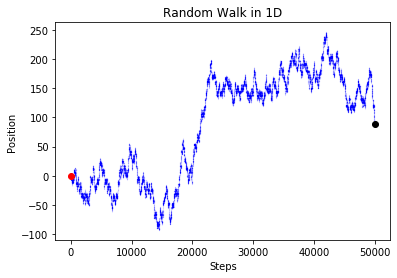

In [124]:
# Defining parameters for the walk
dims = 1
step_n = 50000
step_set = [-1, 1]
origin = np.zeros((1,dims))
# Simulate steps in 1D
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1] # first element 
stop = path[-1:] # last element
# Plot the path
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(np.arange(step_n+1), path, c='blue',alpha=0.35, s=0.005);
plt.plot(0, start, c='red', marker='o')
plt.plot(step_n, stop, c='black', marker='o')
plt.xlabel("Steps")
plt.ylabel("Position")
plt.title('Random Walk in 1D')

Now in 2D:

Text(0.5, 1.0, 'Random Walk in 2D')

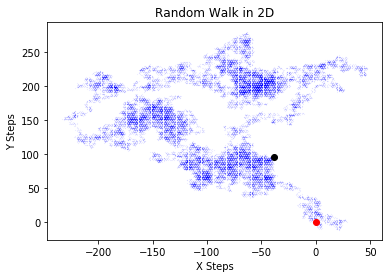

In [125]:
# Defining parameters for the walk
dims = 2
step_n = 50000
step_set = [-1, 1]
origin = np.zeros((1,dims))
# Simulate steps in 1D
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1] # first element 
stop = path[-1:] # last element 
# Plot the path
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(path[:,0], path[:,1],c='blue', alpha=0.35, s=0.005);
plt.plot(start[:,0], start[:,1],c='red', marker='o')
plt.plot(stop[:,0], stop[:,1],c='black', marker='o')
plt.xlabel("X Steps")
plt.ylabel("Y Steps")
plt.title('Random Walk in 2D')

Now in 3D:

Text(0.5, 0.92, 'Random Walk in 3D')

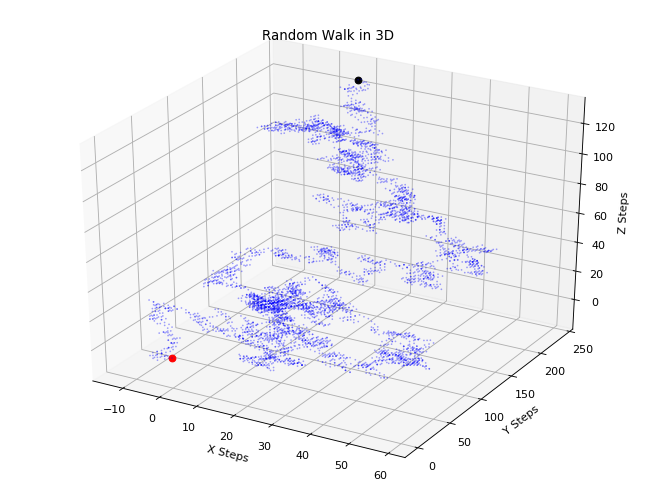

In [126]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure

# Defining parameters for the walk
dims = 3
step_n = 5000
step_set = [-1, 1]
origin = np.zeros((1,dims))
# Simulate steps in 3D
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1] # first element 
stop = path[-1:] # last element
# Plot the path
fig = figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
ax.set_xlabel('X Steps')
ax.set_ylabel('Y Steps')
ax.set_zlabel('Z Steps')
ax.scatter3D(path[:,0], path[:,1], path[:,2], c='blue', alpha=0.35, s=0.3)
ax.plot3D(start[:,0], start[:,1], start[:,2], c='red', marker='o')
ax.plot3D(stop[:,0], stop[:,1], stop[:,2], c='black', marker='o')
plt.title('Random Walk in 3D')

How would you plot it in 4D?

# pdf, cdf, ppf

A [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (pdf) gives us the probability of a random variable assuming a certain value ($y$ from $x$). 

>**Note**: It's the extension of our `p` function to **infinite** dictionaries!

Let's plot the $y$s of the **normal distribution**, for many different $x$s. That's like computing values of our `p` function for a specific key, e.g. `p({x}, SomeProbabilityDistribution)`, or `p(PropertyThatOnlyXHas, SomeProbabilityDistribution)`.

In [127]:
stats.norm.pdf(x=168,         # Value to check for the random variable
               loc=174,       # mean
               scale=8.2)     # standard deviation

0.03722515686677741

In [128]:
stats.norm.pdf(x=174,         # Value to check for the random variable
               loc=174,       # mean
               scale=8.2)     # standard deviation

0.04865149760993082

In [129]:
stats.norm.pdf(x=180,         # Value to check for the random variable
               loc=174,       # mean
               scale=8.2)     # standard deviation

0.03722515686677741

Random variates (rvs) gives us random values from a distribution. But they need not be normalized:

In [130]:
normal_dist = stats.norm.rvs(size=10000, loc=174, scale=8.2, 
                             random_state=0) 

f = pd.Series(normal_dist).plot()

Just for kicks, let's renormalize:

In [ ]:
from sklearn import preprocessing
normal_dist_scaled = preprocessing.MinMaxScaler().fit_transform(pd.DataFrame(normal_dist, columns=['Score']))
normal_dist_scaled.shape

In [107]:
np.squeeze(normal_dist_scaled).shape

(10000,)

In [108]:
f = pd.Series(np.squeeze(normal_dist_scaled)).plot()

Let's plot the histogram:

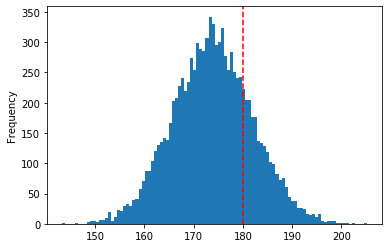

In [135]:
f = pd.Series(normal_dist).plot(kind="hist", bins=100)
f.axvline(180, color='r', linestyle='--')

Let's generate normal random variates, then plot their **histogram**:

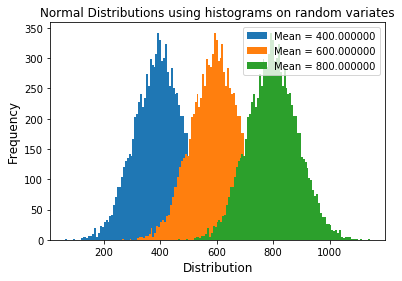

In [165]:
for mean in range(400, 900, 200):
    normal_dist = stats.norm.rvs(size=10000, loc=mean, scale=90, 
                             random_state=0) 
    pd.Series(normal_dist).plot(kind="hist", bins=100, 
                                label="Mean = {:f}".format(mean))
    plt.xlabel('Distribution', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title("Normal Distributions using histograms on random variates")
    plt.legend()

Let's plot the **pdf** of the same normal random variates:

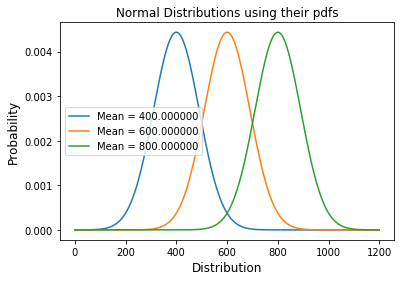

In [167]:
for mean in range(400, 900, 200):
    n = np.arange(0, 1200)
    normal = stats.norm.pdf(n, mean, 90)
    plt.plot(n, normal, label="Mean = {:f}".format(mean))
    plt.xlabel('Distribution', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title("Normal Distributions using their pdfs")
    plt.legend()

In other words, the **pdf** is the *theoretical* **histogram** of a known distribution!

The [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF) gives us the probability that a certain random observation will have a lower value than the one provided:

In [139]:
stats.norm.cdf(x=186,         # Cutoff value (quantile) to check
               loc=174,       # Mean
               scale=8.2)     # Standard Deviation

0.9283230216395894

The [percent point function](https://en.wikipedia.org/wiki/Quantile_function) (PPF), also called [quantile function](https://en.wikipedia.org/wiki/Quantile_function) gives us the quantile using a probability as input (inverse of cumulative distribution function) ($x$ from $y$).

In [140]:
stats.norm.ppf(q=0.93,      # Cutoff value (quantile) to check
               loc=174,     # Mean
               scale=8.2)   # Standard Deviation

186.1014864310692

# 4. Distribution transformations

<div style="display: none;">
x = [0,1,2,3,4,5,6]
counts, bins = np.histogram(x, bins= 100)
bins = bins[:-1] + (bins[1] - bins[0])/2
probs = counts/float(counts.sum())
print(probs.sum()) # 1.0
plt.bar(bins, probs)
plt.show()

probs = np.full((6), 1/6)
face = \[1,2,3,4,5,6]
plt.bar(face, probs)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Dice Roll Outcome', fontsize=12)
plt.title('Fair Dice Uniform Distribution', fontsize=12)
axes = plt.gca()
axes.set_ylim([0,1])

probs = np.array([0.25, 0.125, 0.05, 0.4, 0.125, 0.05])
face = [1,2,3,4,5,6]
plt.bar(face, probs)
plt.title('Loaded dice (not uniform distribution)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Dice Roll Outcome', fontsize=12)
axes = plt.gca()
axes.set_ylim([0,1])

n = np.arange(1, 7)
mean = 3.5
gaussian_dice = stats.norm.pdf(n, mean, 0.9)
plt.plot(n, gaussian_dice)

face = [1,2,3,4,5,6]
plt.bar(face, gaussian_dice)
plt.title('Loaded dice (gausian distribution)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Dice Roll Outcome', fontsize=12)
axes = plt.gca()
axes.set_ylim([0,1])
</div>

<center>
    <img src="ipynb.images/birds-up.png" width=400 />
</center>

Real-world data can be messy. Some datasets contain attributes that need severe modifications before they can be used to do predictive modeling. What do I mean by that? I mean that ***more reliable predictions can be made if the predictors and the
target variable are closer to a normal distribution***. One way to getting them there if they're not is to *apply a transform to them*. Let's look at an example.

We're in Boston, so let's use a familiar Boston Housing Prices dataset to explore some techniques of
dealing with skewed data. There is no need to download it, as we can import it straight from `Scikit-learn`:

In [45]:
from sklearn.datasets import load_boston

boston = load_boston()
x = boston['data']
y = boston['target']
cols = boston['feature_names']

df = pd.DataFrame(x, columns = cols)
df['Price'] = y
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  Price  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

How skewed is the `CRIM` column?

In [46]:
df['CRIM'].skew()

5.223148798243851

Oh, that's a lot! Let's use the Seaborn library to make a histogram alongside with the KDE plot. 

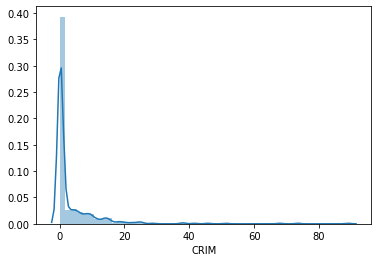

In [47]:
sns.distplot(df['CRIM'])

Let’s explore some methods for handling *skewed* data.

## Log Transform
Log transformation is most likely the first thing you should do to remove skewness from the predictor.
It can be easily done via `Numpy`, just by calling the log() function on the desired column

In [50]:
crim_log = np.log(df['CRIM'])
crim_log.skew()

0.4059344988496048

In [51]:
sns.distplot(crim_log)

Much nicer, right? It’s not normally distributed for sure, but is a lot better than what we had before!

The log transformation isn’t the only one you can use. Let’s explore a couple of more options.

## Square Root Transform
The square root sometimes works great and sometimes isn’t the best suitable option. In this case, I still expect the transformed distribution to look somewhat exponential, but just due to taking a square root the range of the variable will be smaller.

In [53]:
crim_sqrt = np.sqrt(df['CRIM'])
crim_sqrt.skew()

2.024382103123676

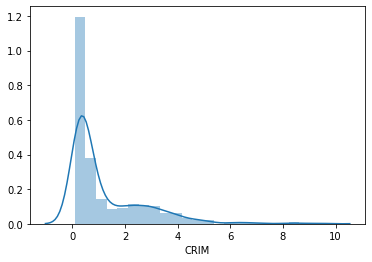

In [54]:
sns.distplot(crim_sqrt)

The distribution is pretty much the same, but the range is smaller, as expected.

## Box-Cox Transform
The [Box-Cox transform](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation), named after statisticians [George Box](http://mathshistory.st-andrews.ac.uk/Biographies/Box.html) and [Sir David Roxbee Cox](https://www.britannica.com/biography/David-Cox-British-statistician) who collaborated on a 1964 paper and developed the technique, is the classical way for handling skewed data. To use it, your data must be positive — so that can be a bummer sometimes.

At the core of the Box Cox transformation is an exponent, $λ$, which varies from -5 to 5. All values of $λ$ are considered and the optimal value for your data is selected; The *optimal value* is the one which results in the best approximation of a normal distribution curve.

You can import the Box-Cox transform from `Scipy`, but the check for the skew you’ll need to convert the resulting Numpy array to a Pandas Series:

In [56]:
from scipy import stats

crim_boxcox = stats.boxcox(df['CRIM'])[0]
pd.Series(crim_boxcox).skew()

0.09364917268984103

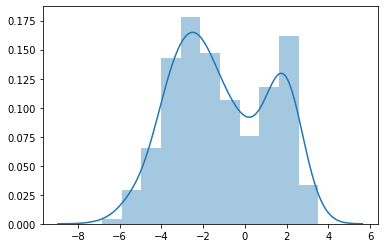

In [57]:
sns.distplot(crim_boxcox)

The distribution is pretty similar to the one made by the log transformation, but just a touch less bimodal in dispersion (since the two bumps are closer together), but more bimodal in centrality (since the two bumps are of almost equal magnitude).

Skewed data can mess up the power of your predictive model if you don’t address it correctly.

Should go without saying, but you should remember what transformation you’ve performed on which attribute, because you’ll *have to reverse it once when making predictions*!

In general, conducting transformations on the data before modeling it goes by the name of **kernel methods**.

# 5. Kernel Methods and Support Vector Machines for Classification
Ok, so all of these distributions are potential models for your datasets.

>**The Job**: Have a dataset? Evaluate its histogram. Does it look like one of the models above? Great, find its parameters and you're done! Netflix tonite!

We will see in our time series notebook that a simple model can learn a simple dataset, but when we make the prediction more challenging by dividing the past and the future, simple models may fail. But a deeper model may succeed, even though all it succeeds to do is to observe that *if you time-shift to the left, then the best prediction is to time-shift to the right by the same amount*. Duh.

The [bias-variance dilemma](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) dominates machine learning methods. If a model is too simple, the model will struggle to find appropriate relationships between inputs and outputs. However, if a model is too complex, it will perform well in training, but it will experience a reduction in performance on **unseen data**. 

In an ideal world, we want a *simple* model that is fast to train, and a model *complex* enough to find complex relationships between inputs and outputs. For example, an ANN may be deep enough to learn that a time shift of 30 days to the right is the good answer. 

**Kernel methods** find good answers by mapping the input space of the data to a higher dimensional feature space, in which simple linear models can be trained, resulting in efficient, low bias low variance models. It's a bit like our data transformation methods above (Log transform, box-cox transform).

>Researchers today think that kernel methods will help us understand how deep learning interpolates multi-dimensional data.

### References
- [Kernel Methods for Deep Learning](https://papers.nips.cc/paper/2009/hash/5751ec3e9a4feab575962e78e006250d-Abstract.html)

- [To understand deep learning we need to understand kernel learning](https://arxiv.org/abs/1802.01396)

- [Deep Kernel: Learning Kernel Function from Data Using Deep Neural Network](https://ieeexplore.ieee.org/document/7877043)

There are many kernel methods used in the machine learning world. Support Vector Machines (SVMs), which we will look at closer in out time-series notebook, are popular. Nowadays, kernel methods are most suited for small to medium datasets, and in problems where the explainability of the results is important.

Kernel methods use **kernels** (or basis functions) to map the input data into a different space. After this mapping, simple models can be trained on the new feature space, instead of the input space, which can result in an increase in the performance of the models.

Let's introduce some libraries:

In [131]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_moons
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# matplotlib  3.1.2
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("data/output/") : os.mkdir("data/output/")

We already used an `SVM` regressor. Let's simplify to a classification use-case and explain how Support Vector Machines work.

Instead of **generative classification** where we actually generate the two classes, we will consider **discriminative classification**. So, rather than modeling each class, we simply find a `line` or `curve` (in two dimensions) or `manifold` (in multiple dimensions) that *divides* the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

In [132]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

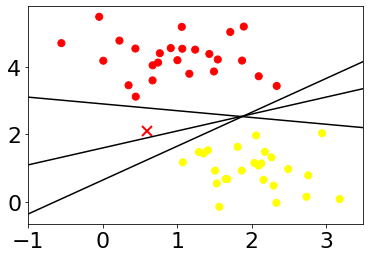

In [133]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the Margin
Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

In [134]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

## Fitting a support vector machine
Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the `C` parameter to a very large number.

In [135]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [136]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [137]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier:

In [138]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

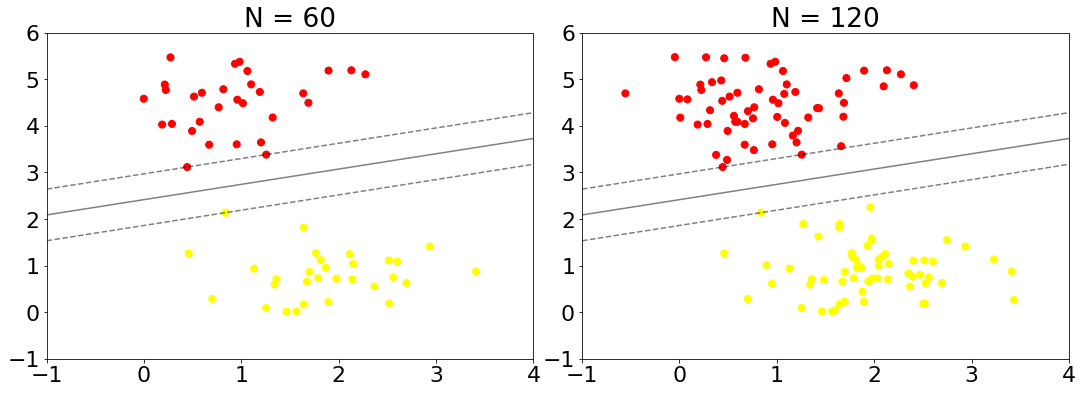

In [90]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

## Beyond linear boundaries: Kernel SVM
Where SVM becomes extremely powerful is when it is combined with kernels. We have seen a version of kernels before, in the basis function regressions of In Depth: Linear Regression. There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable. A famous synthetic dataset in this category, called the two-moon dataset, can be illustrated in 2-D:

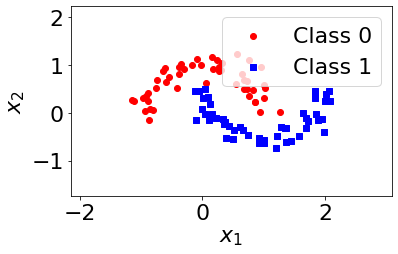

In [139]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=0)

plt.scatter(X[y == 0, 0], X[y == 0, 1],
            c='r', marker='o', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            c='b', marker='s', label='Class 1')

plt.xlim(X[:, 0].min()-1, X[:, 0].max()+1)
plt.ylim(X[:, 1].min()-1, X[:, 1].max()+1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('data/output/fig-two-moon.png', dpi=300)
plt.show()

This is a function for plotting decision regions, detailed [here](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/). It usually installs with the libraries I have you install, but if it doesn't, then you need to:
```
pip install mlxtend
```

In [92]:
from mlxtend.plotting import plot_decision_regions

If we apply **linear** classifiers such as `Perceptron` or `Logistic Regression` to this dataset, it is not possible to get a reasonable decision boundary:

[Perceptron]
Misclassified samples: 3
Accuracy: 0.85


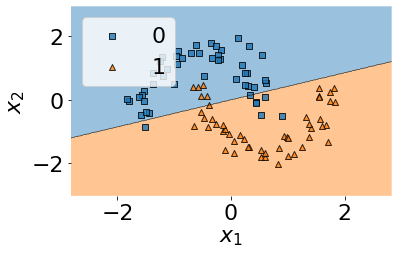

[Logistic regression]
Misclassified samples: 3
Accuracy: 0.85


In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# A simple one-layer ANN:
ppn = Perceptron(max_iter=1000, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('[Perceptron]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for Perceptron
plot_decision_regions(X_combined_std, y_combined,
                      clf=ppn) #, 
                      #classifier=ppn
                      #test_idx=range(y_train.size, 
                      #               y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('data/output/fig-two-moon-perceptron-boundray.png', dpi=300)
plt.show()

# A logistic regressor:
lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('[Logistic regression]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for LogisticRegression
plot_decision_regions(X_combined_std, y_combined,
                      clf=lr) #, 
                      #test_idx=range(y_train.size, 
                      #               y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('data/output/fig-two-moon-logistic-regression-boundray.png', dpi=300)
plt.show()

As we can see, neither of the classifiers can separate the two classes well due to underfitting. In other words, the models are ***too simple*** to capture the shape of true boundary, introducing a large bias. It is a bit like if I ask you to compute the Einstein general relativity equation for Mars moving around the sun. Your brain does not have enough training on the theory to be able to compute.

It is better to use nonlinear classifiers like kernem methods for this dataset.

Kernel methods work by taking complex non-linearly separable shapes and projecting them into an extra dimension to make them **linearly** separable. Look at an example here.

The figure below is clearly not linearly separable: You cannot draw a line that separates the two classes:

<left>
<img src="ipynb.images/kernel-1.png" width=500 />
</left>

But look what happens if you project and distort the image into 3D:

<br />
<left>
<img src="ipynb.images/kernel-2.gif" width=500 />
</left>

Can you now separate the two images with a hyperplane (generalization of a line into 3D)?

Support Vector Classifiers (SVC) enhanced with kernel functions make predictions by the weighted average of labels of similar examples *as measured by a kernel function*. 

Only the support vectors, i.e., examples falling onto or inside the margin, can have positive weights and need to be remembered. So SVCs usually remember with much fewer examples than other non-linear classifiers. Also, SVC is an *eager learner*: Weights are trained eagerly in the training phase.

We won't focus on the mechanics of SVCs with kernel methods right now. Programming them is material for more advanced classes. But it's good to see how to use `scikit-learn` to call these methods:

[Linear SVC]
Misclassified samples: 3
Accuracy: 0.85


[Nonlinear SVC]
Misclassified samples: 1
Accuracy: 0.95


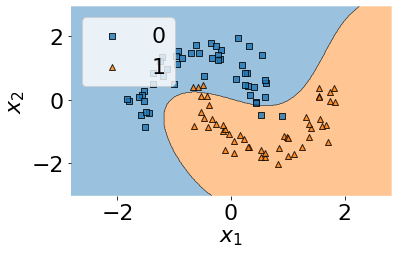

In [141]:
# kernel: the kernel function, can be 'linear', 'poly', 'rbf', ...etc
# C is the hyperparameter for the error penalty term
svm_linear = SVC(kernel='linear', C=1000.0, random_state=0)

svm_linear.fit(X_train_std, y_train)
y_pred = svm_linear.predict(X_test_std)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for linear svm
plot_decision_regions(X_combined_std, y_combined,
                      clf=svm_linear) #, 
                      #test_idx=range(y_train.size,
                      #               y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('data/output/figtwo-moon-svm-linear-boundray.png', dpi=300)
plt.show()

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_rbf = SVC(kernel='rbf', random_state=0, gamma=0.2, C=10.0)

svm_rbf.fit(X_train_std, y_train)
y_pred = svm_rbf.predict(X_test_std)
print('[Nonlinear SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for rbf svm
plot_decision_regions(X_combined_std, y_combined,
                      clf=svm_rbf) #, 
                      #test_idx=range(y_train.size, 
                      #               y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('data/output/fig-two-moon-svm-rbf-boundray.png', dpi=300)
plt.show()

As we can see, non-linear SVC achieves 95% accuracy. However, we haven't tuned its **hyperparameters** to get the *best* performance yet. Let's try other values:

In [142]:
print('[Nonlinear SVC: C=1000, gamma=0.01]')
svm = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1000.0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

print('\n[Nonlinear SVC: C=1, gamma=1]')
svm = SVC(kernel='rbf', random_state=0, gamma=0.0001, C=10.0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[Nonlinear SVC: C=1000, gamma=0.01]
Misclassified samples: 3
Accuracy: 0.85

[Nonlinear SVC: C=1, gamma=1]
Misclassified samples: 11
Accuracy: 0.45


From the above example, we can see that tuning the hyperparameters is very important to nonlinear SVC. Different parameter setting will make huge performance difference.

One of the reasons I like random forests and I use them as an introduction to computer-assisted data modeling (CADM - that is a monicker that I invented!) is because random forests don't have hyperparameters to tinker with, and so are easy to use. But for more advanced modeling, you need to tune hyperparameters.

## Tuning Hyperparameters via Grid Search
Tuning the hyperparameters of SVC is not straightforward. We can't simply increase a polynomial degree from 1 and stop if the validation performance does not improve anymore, for example. In SVC, there is no simple way to relate a particular hyperparameter combination  (C,γ)  to the model complexity. 

So, we have to try out all possible (or specified) combinations exhaustively in order to pick the best one. This procedure is called **grid search**:

In [143]:
param_C = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

svm = SVC(random_state=0)

# set the param_grid parameter of GridSearchCV to a list of dictionaries
param_grid = [{'C': param_C, 
               'gamma': param_gamma, 
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy')

gs = gs.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9625
{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}


After finding the best parameter, we can then use it to evaluate on test data:


[Nonlinear SVC: grid search]
Test accuracy: 1.00


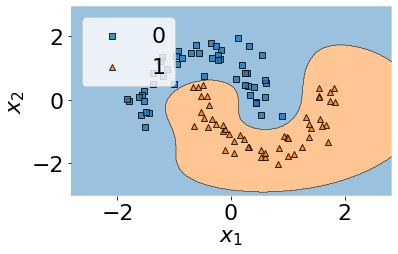

In [144]:
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
print('\n[Nonlinear SVC: grid search]')
print('Test accuracy: %.2f' % clf.score(X_test_std, y_test))

# plot decision regions for rbf svm
plot_decision_regions(X_combined_std, y_combined,
                      clf=gs.best_estimator_) #, 
                      #test_idx=range(y_train.size, 
                      #               y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('data/output/fig-two-moon-svm-rbf-gs-boundray.png', dpi=300)
plt.show()

Wow! We have perfect test accuracy. That's great!

NOTE: grid search may consume a lot of time when the dataset is large. A practical way is to use coarse grids initially, narrow down into some grids that gives relatively good performance, and then perform more fine-grained grid searches within those grids recursively.

Here's something on youtube that explains the math behind the analogies of kernel methods and deep learning through gradient descent. It's the state of the art in machine learning (note: math lives here)!

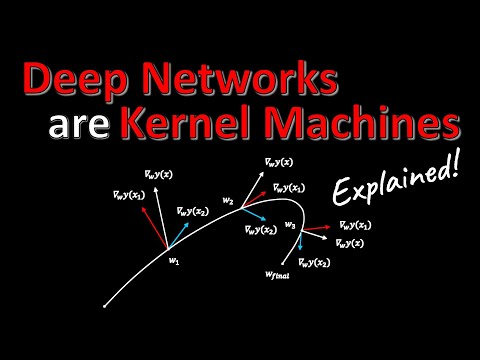

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('ahRPdiCop3E')